<h2>Team Busters</h2>

<h4>School of quants. Hackathon</h4>


<h4>Team members</h4>
<ul>
    <li>Mikhail Mironov</li>
    <li>Alexander Illyuk</li>
    
</ul>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from typing import *

In [28]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h4>Load data</h4>

In [29]:
BASE_DIR = "/content/drive/MyDrive/quants_final"

df_train = pd.read_csv(f"{BASE_DIR}/data/train.csv")
df_test = pd.read_csv(f"{BASE_DIR}/data/test.csv")

df = pd.concat([df_train, df_test], axis=0)
df.shape

(1707198, 39)

In [30]:
train_size, test_size = df_train.shape[0], df_test.shape[0]
df = df.reset_index(drop=True)

In [31]:
df = df.convert_dtypes()

<h4>Create some features</h4>

In [32]:
for i in range(1, 4):
    df[f"channel_{i}"] = df[f"resist{i}"] - df[f"support{i}"]

<h4>Feature encoding</h4>

<p>We have multiple categorical features which are encoded using buy/sell/hold signals. Now we will simply use dummies encoding than we might use something fancy like Catboost numeric encoding of categorical features</p>

In [33]:
# categorical features from TA
cat_cols = [
   "rsi_sig", "fibo_sig", "ichi_sig", "stoch_sig", "boll_sig", "exch"
]

In [34]:
def create_cat_cols(df: pd.DataFrame) -> Tuple[pd.DataFrame, List[str]]:
    categorical_cols = []

    for col in tqdm(cat_cols):

        cat_dummies = pd.get_dummies(df[col], prefix=col)

        categorical_cols.extend(
            cat_dummies.columns.tolist()
        )

        df = pd.concat([df, cat_dummies], axis=1)

    return (
        df, categorical_cols
    )

In [35]:
df, categorical_cols = create_cat_cols(df)

100%|██████████| 6/6 [00:03<00:00,  1.70it/s]


<h4>Define feature columns</h4>

In [36]:
# cols contains categorical signals encoded with dummies and all of the other numerical features
cols = set(df.columns) - set(["result"]) - set(cat_cols) # remove and not encoded categorical columns
cols = list(cols)

In [37]:
# numeric columns
num_cols = list(set(cols) - set(categorical_cols))

df[num_cols] = df[num_cols].astype(np.float64)

<h4>Anomaly detection</h4>

<p>Now I have to scale data to help convergence of catboost as well as bring variance to the same scale for PCA. But to ensure that PCA results are not offset by outliers (I am not sure sklearn uses Robust PCA) we are just better off removing all outliers.</p>

In [38]:
from sklearn.preprocessing import StandardScaler

X = df[num_cols].values
Xs = StandardScaler().fit_transform(X)

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=Xs.shape[1])
PCA_proj = pca.fit_transform(Xs)

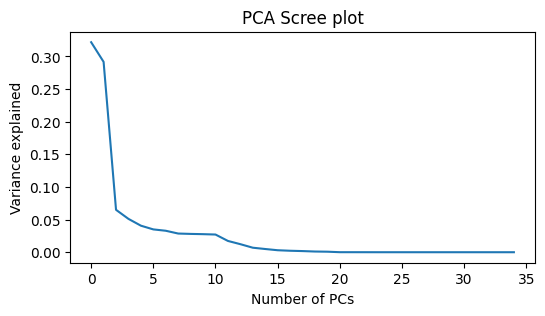

In [40]:
plt.figure(figsize=(6, 3))
plt.title("PCA Scree plot")

plt.xlabel("Number of PCs")
plt.ylabel("Variance explained")

plt.plot(pca.explained_variance_ratio_)

plt.savefig("pca_scree_plot.png", bbox_inches="tight")

plt.show()

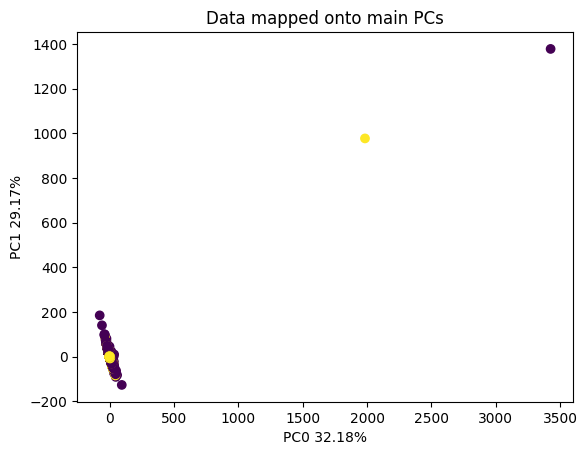

In [41]:
plt.scatter(PCA_proj[:, 0], PCA_proj[:, 1], c=df["result"])

plt.title("Data mapped onto main PCs")
plt.xlabel(f"PC0 {round(pca.explained_variance_ratio_[0]*100, 2)}%")
plt.ylabel(f"PC1 {round(pca.explained_variance_ratio_[1]*100, 2)}%")

plt.savefig("pca_initial.png", bbox_inches="tight")

plt.show()

<p>From the plot above we can clearly see that there are two obvious outliers. We should exclude them since they will heavily offset the mean and std of the sample. This will be important for scaling data since we would like to use estimates closer to population moments.</p>

<p>In this case it is valid to use PCA to spot and remove these outliers since two main Principal Components account for the majority of the variance in the initial data</p>

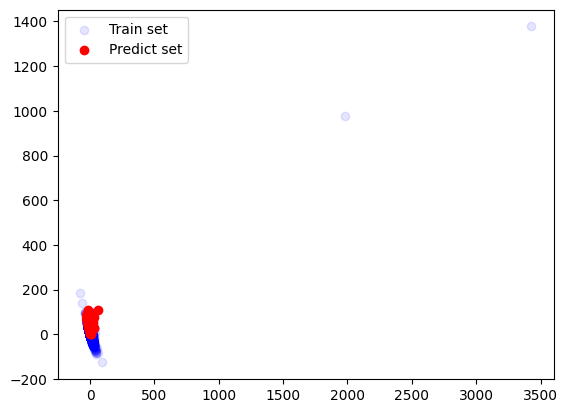

In [42]:
df_sol = pd.read_csv(f"{BASE_DIR}/data/solution.csv")

for i in range(1, 4):
    df_sol[f"channel_{i}"] = df_sol[f"resist{i}"] - df_sol[f"support{i}"]

Sol_proj = pca.transform(
    df_sol[num_cols].values
)

plt.scatter(PCA_proj[:, 0], PCA_proj[:, 1], c="b", alpha=0.1, label="Train set")
plt.scatter(Sol_proj[:, 0], Sol_proj[:, 1], c="r", label="Predict set")

plt.legend()
plt.show()

<h4>Remove spotted outliers</h4>
<p>We have two obvious outliers in the PCA plot above. We should definately remove them as they offset sample mean and standard deviation heavily which will negatvely affect the standartisation and hence the results.</p>

In [43]:
filtered_idx = np.where(PCA_proj[:, 0] < 500)[0]

len(filtered_idx), df.shape[0]

(1707196, 1707198)

In [44]:
# remove those 2 outliers

df_filtered = df.iloc[filtered_idx].copy()
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.shape

(1707196, 61)

<h4>(Robust) PCA without outliers</h4>

<p>Below we can see the picture more clearly, as we remove outliers, now we can see

In [45]:
X = df_filtered[num_cols].values
Xs = StandardScaler().fit_transform(X)

In [46]:
pca = PCA(n_components=Xs.shape[1])
PCA_proj = pca.fit_transform(Xs)

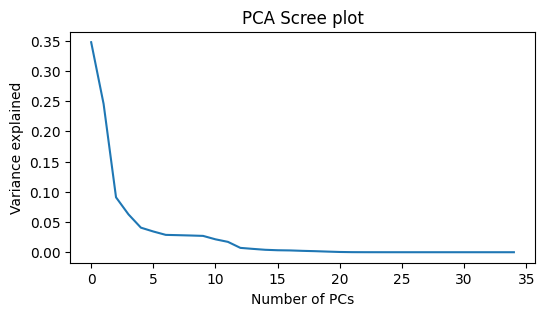

In [21]:
plt.figure(figsize=(6, 3))
plt.title("PCA Scree plot")

plt.xlabel("Number of PCs")
plt.ylabel("Variance explained")

plt.plot(pca.explained_variance_ratio_)

plt.show()

In [47]:
df_sol[num_cols] = (
    df_sol[num_cols] - df_filtered[num_cols].mean(axis=0)
) / df_filtered[num_cols].std(axis=0)

Sol_proj = pca.transform(df_sol[num_cols].values)

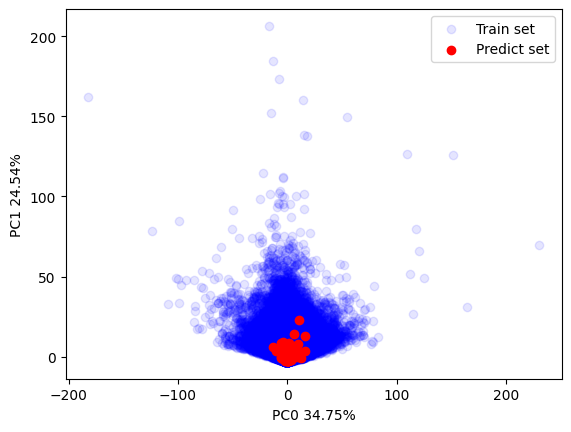

In [48]:
plt.scatter(PCA_proj[:, 0], PCA_proj[:, 1], c="b", alpha=0.1, label="Train set")
plt.scatter(Sol_proj[:, 0], Sol_proj[:, 1], c="r", label="Predict set")

plt.xlabel(f"PC0 {round(pca.explained_variance_ratio_[0]*100, 2)}%")
plt.ylabel(f"PC1 {round(pca.explained_variance_ratio_[1]*100, 2)}%")
plt.legend()

plt.savefig("pca_clean.png", bbox_inches="tight")

plt.show()

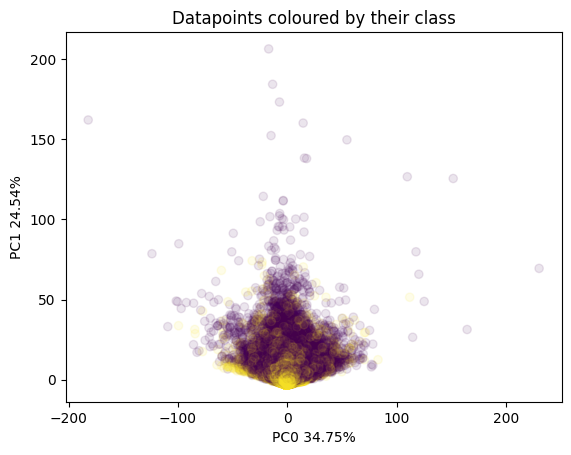

In [51]:
plt.scatter(PCA_proj[:, 0], PCA_proj[:, 1], c=df_filtered["result"], alpha=0.1)

plt.title("Datapoints coloured by their class")

plt.xlabel(f"PC0 {round(pca.explained_variance_ratio_[0]*100, 2)}%")
plt.ylabel(f"PC1 {round(pca.explained_variance_ratio_[1]*100, 2)}%")

plt.savefig("pca_clean_classes.png", bbox_inches="tight")

plt.show()

<h4>Scale data using filtered data</h4>

<p>Below I also checked how those two outliers would have offset the mean and std</p>

In [52]:
df_means = pd.DataFrame({
    "feature": num_cols,
    "corrected_mean": df_filtered[num_cols].mean().tolist(),
    "noised_mean": df[num_cols].mean().tolist()
})

In [54]:
df_means["diff_to_scale"] = np.abs(
    (df_means["corrected_mean"] - df_means["noised_mean"]) / df_means["corrected_mean"]
)
df_means.sort_values(by="diff_to_scale", ascending=False).head()

,feature,corrected_mean,noised_mean,diff_to_scale
25,ichi_b,-0.019874,-0.014857,0.252442
11,pivot_pt,-0.011122,-0.009556,0.140745
27,support1,-1.196541,-1.213082,0.013824
13,resist2,2.364921,2.386163,0.008982
29,resist3,4.740965,4.781883,0.008631


<h4>Scale data using filtered sample</h4>

In [56]:
df_scaled = df_filtered.copy()

df_scaled[num_cols] = (
    df_scaled[num_cols] - df_scaled[num_cols].mean(axis=0)
) / df_scaled[num_cols].std(axis=0)

In [28]:
corr = df_scaled.corr(numeric_only=True)

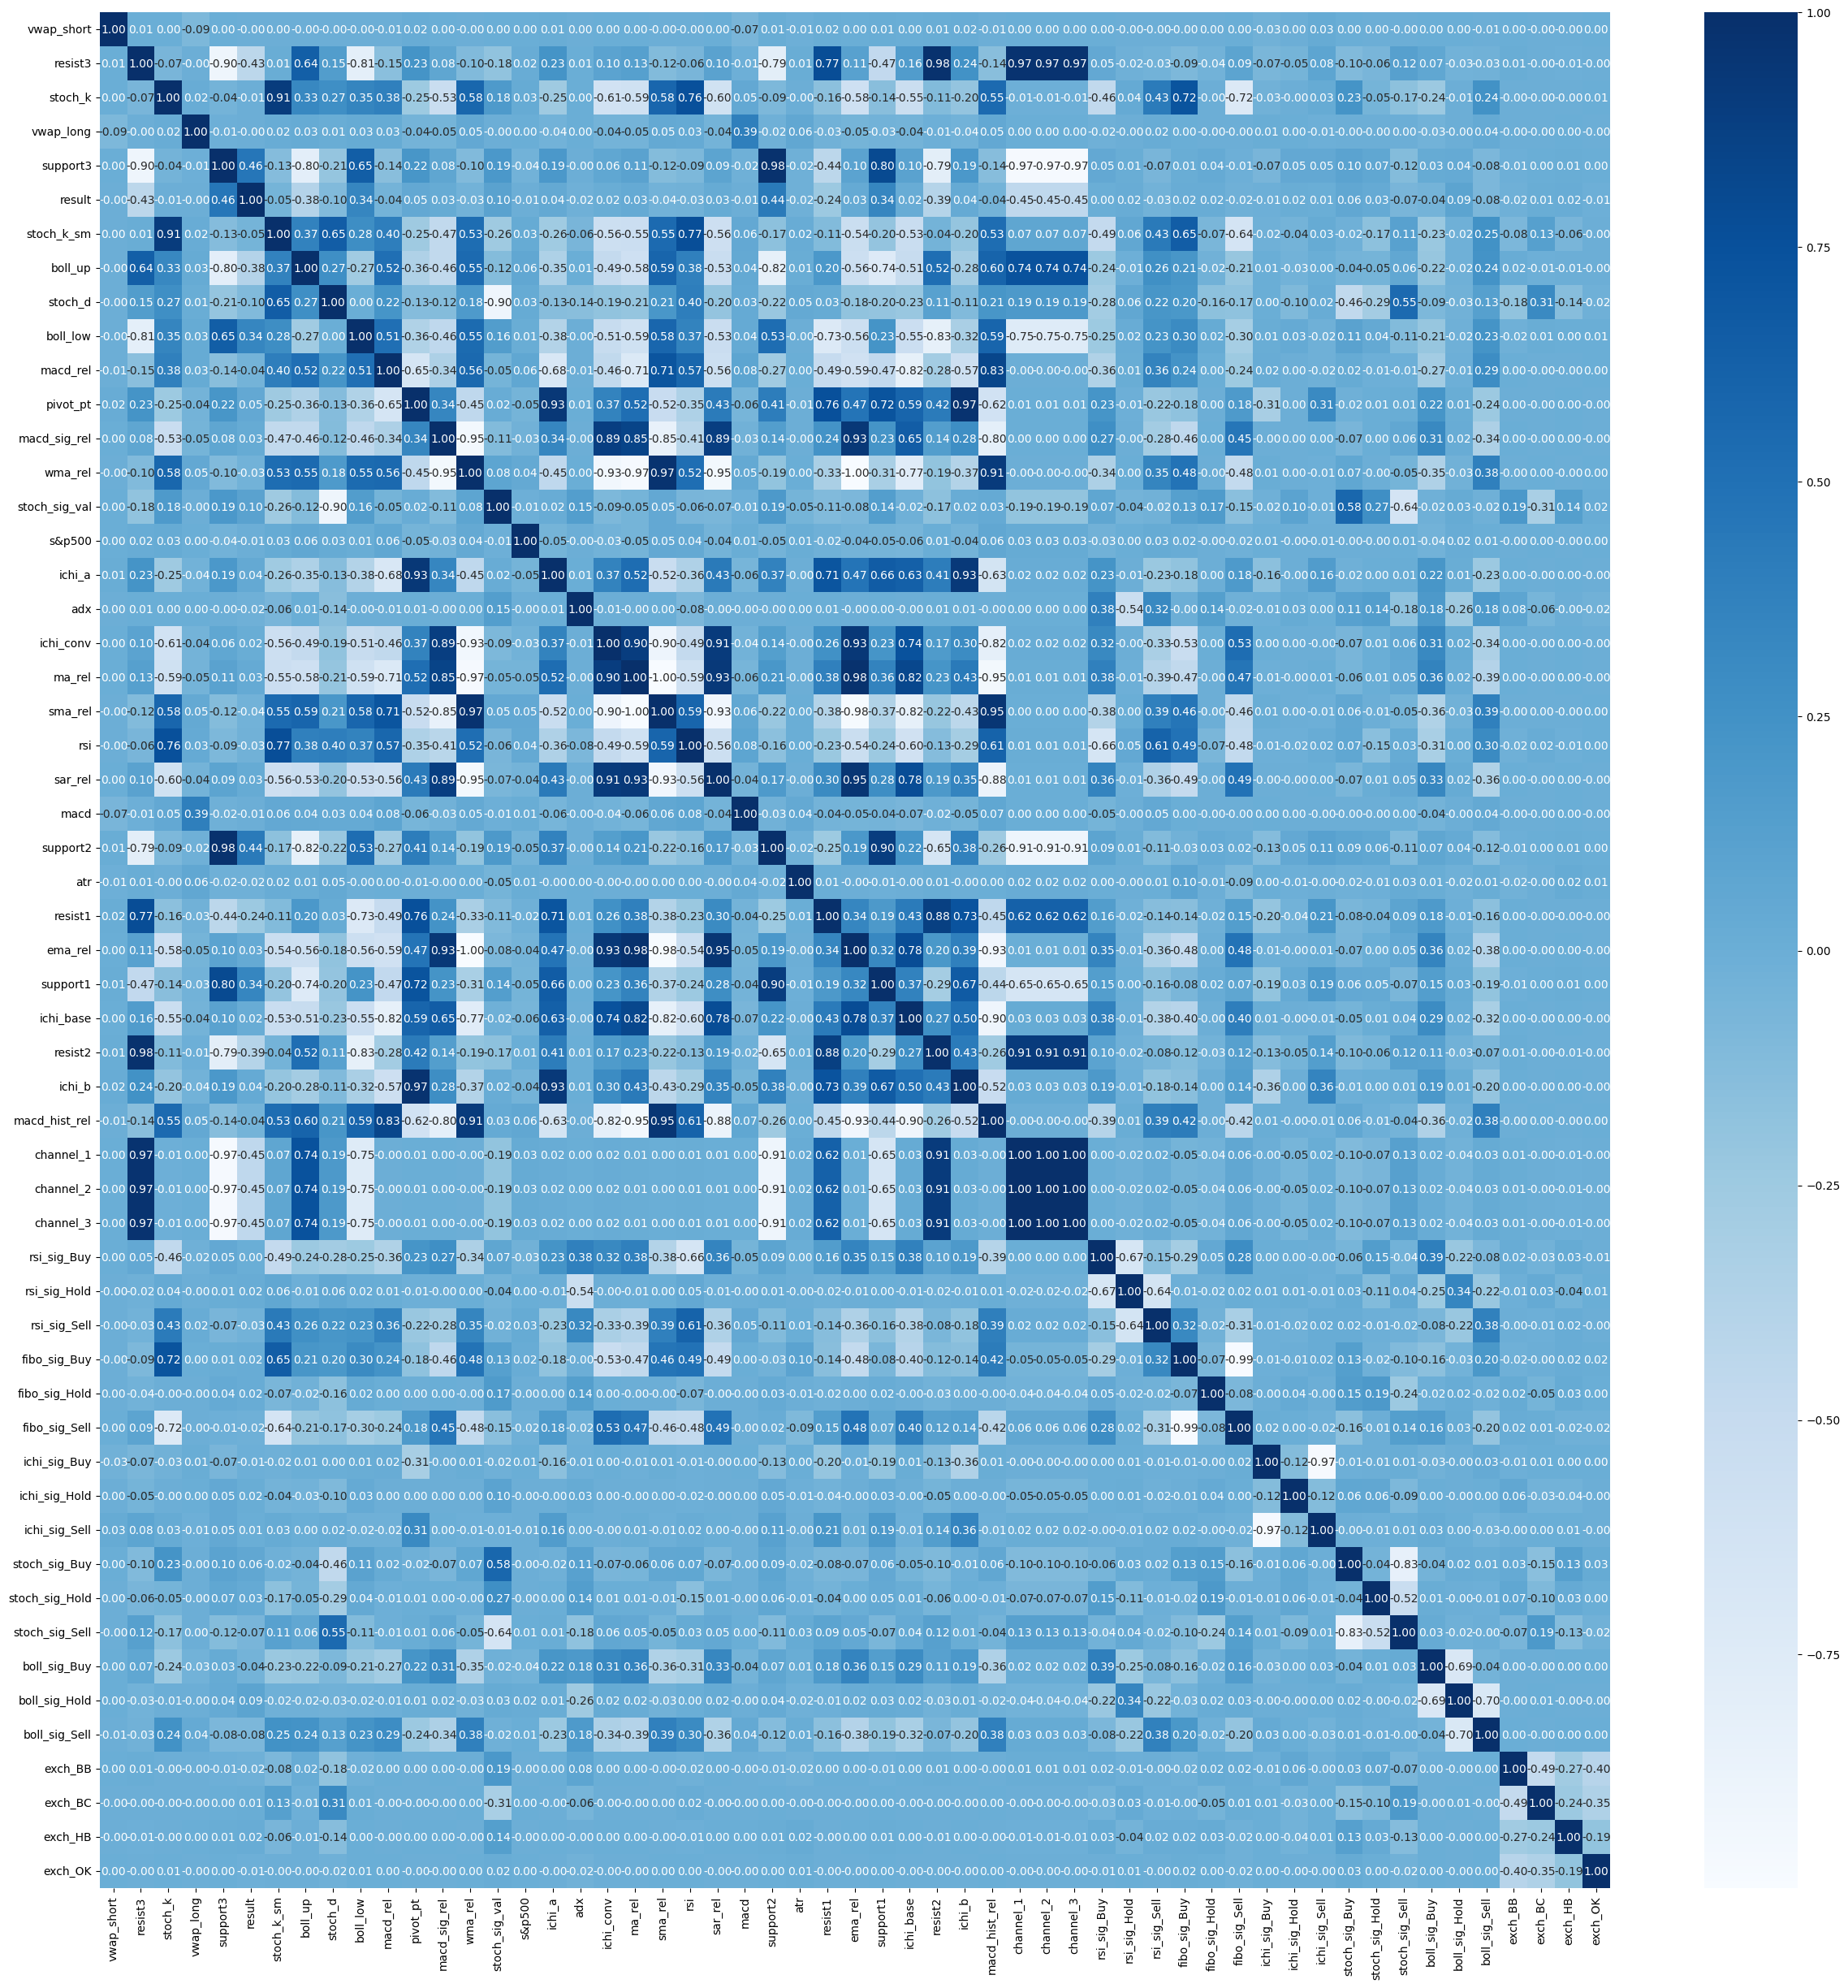

In [29]:
plt.figure(figsize=(30, 30))

sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    cmap=plt.cm.Blues
)

plt.show()

<h4>Train test val split</h4>

In [57]:
from sklearn.model_selection import train_test_split

df_train_val, df_test = train_test_split(
    df_scaled, random_state=42, shuffle=True, train_size=0.8
)

df_train, df_val = train_test_split(df_train_val, train_size=0.9)

In [62]:
df_train["result"].value_counts(), df_val["result"].value_counts()

(1    1094609
 0     134571
 Name: result, dtype: Int64,
 1    121812
 0     14764
 Name: result, dtype: Int64)

<p>We see that the data is split preserving the same imbalance ratio. Since we have a lot of data, we won't use KFold crossvalidation or RepeatedKFold crossvalidation since doing this would've taken much much longer to train, tune and validate the models. Therefore, we just left off a separate validation set which seems to be representative and more or less the same as train.</p>

<h4>Baseline Catboost boosting model</h4>

<p>Since we already know the performance of the dummy classifier along with Logistic Regression. We will jump straight into more complicated models. We will train Catboost classifier with early stopping on the validation set which means that once we get no improvement on the validation set we will stop training as it will lead to overfitting.</p>

In [32]:
# !pip install catboost
# !pip install optuna

In [66]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

reg_cols = num_cols + cat_cols

In [59]:
# create pools
train = Pool(data=df_train[reg_cols], label=df_train["result"], cat_features=cat_cols)
val = Pool(data=df_val[reg_cols], label=df_val["result"], cat_features=cat_cols)
test = Pool(data=df_test[reg_cols], label=df_test["result"], cat_features=cat_cols)

<p>Catboost is very slow to train we might use some other boosting library to improve on this result</p>

In [ ]:
# Default catboost model with categorical features with early stopping

params = {
    "learning_rate": 0.3,
    "task_type": "GPU",
    "devices": "0"
}

model = CatBoostClassifier(
    **params,n_estimators=3000,
)

model.fit(
    train,
    eval_set=val,
    use_best_model=True,
    early_stopping_rounds=10,
    verbose=True,
)

In [64]:
# check target metric
y_pred = model.predict(val)

f1_score(y_pred=y_pred, y_true=df_val["result"], average="micro")

0.932755388940956

<p>We already see that overall this model is already good enough, it scores higher than the baseline of dummy classifier and Logistic regression suggested by the authors of the case. Below we see the confusion matrix, there is no obvious problem with this model. It would've been much worse if we saw that the model always predicts 0 to discover all of the minority class observations. This would have been pretty bad, but we see that this is not the case. This model already is well behaved having high enough precision and recall. It is already great that we have 0.64 f1-score for the minority class. Usually for imbalanced data like this I would observe f1-score for minority class of 0.4-0.5 which is already good. Having f1-score this high means that there is actual connection between data and target variable.</p>

In [69]:
print(classification_report(y_pred=y_pred, y_true=df_val["result"]))

              precision    recall  f1-score   support

         0.0       0.76      0.55      0.64     14764
         1.0       0.95      0.98      0.96    121812

    accuracy                           0.93    136576
   macro avg       0.85      0.77      0.80    136576
weighted avg       0.93      0.93      0.93    136576



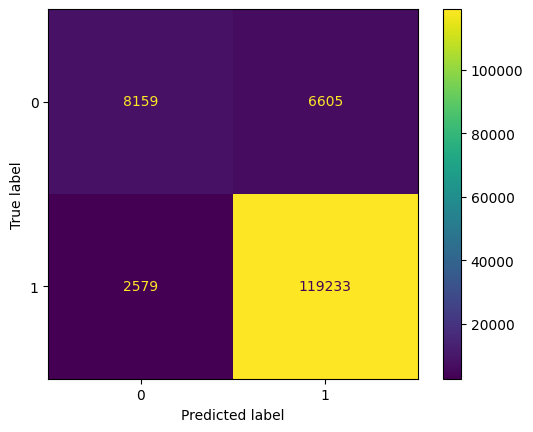

In [65]:
cm = confusion_matrix(y_pred=y_pred, y_true=df_val["result"])

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[0, 1]
).plot()

plt.show()

<h4>Optimize Catboost for target F1 micro</h4>

<p>In order to find optimal hyperparameters for the model, we will use optuna which implements Bayseian approach to optimisation of hyperparamters. It is a smarter way to go through hyperparamters than GridSearch or RandomGridSearch. Especially given that dataset is large, we are limited with the number of trains we can perform, therefore, optuna turned out to be a great tool</p>

In [70]:
from functools import partial
from sklearn.metrics import f1_score

import optuna

In [39]:
def catboost_objective(
    trial: optuna.Trial, train: Pool, val: Pool
) -> float:

    cb_params = {
        "objective": "Logloss",

        "learning_rate": trial.suggest_float("learning_rate", 0.1, 1, log=True),
        "depth": trial.suggest_int("depth", 2, 15),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.0001, 0.3, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.01, 10),
        "eval_metric": "Logloss",

        "task_type": "GPU",
        "devices": "0",
        "random_seed": 42,
    }

    # Fit the model with early stopping
    model = CatBoostClassifier(
        **cb_params, n_estimators=5000,
    )

    model.fit(
        train,
        eval_set=val,
        use_best_model=True,
        early_stopping_rounds=10,
        verbose=False,
    )

    y_pred = model.predict(val)

    f1_micro = f1_score(y_true=df_val["result"], y_pred=y_pred, average="micro")

    return f1_micro

In [ ]:
study_catboost = optuna.create_study(
    direction="maximize",
)

study_catboost.optimize(
    partial(catboost_objective, train=train, val=val),
    n_trials=100
)

<p>After running 100 optuna trials we managed to find these parameters. For the sake of not rerunning this everytime they are defined below</p>

In [71]:
# study_catboost.best_params

best_cb_params = {
    'learning_rate': 0.32458977674493483,
    'depth': 5,
    'l2_leaf_reg': 0.0027481863262437916,
    'scale_pos_weight': 0.9440431945988185
}

<h4>Train tuned CatBoost model</h4>

In [ ]:
cb_tuned_params = {
    "objective": "Logloss",
    "learning_rate": 0.3,
    "task_type": "GPU",
    "devices": "0",
    "eval_metric": "Logloss"
}

cb_tuned_params.update(best_cb_params)

model = CatBoostClassifier(
    **cb_tuned_params, n_estimators=5000,
)

model.fit(
    train,
    eval_set=val,
    use_best_model=True,
    early_stopping_rounds=10,
    verbose=True,
)

In [73]:
# check target metric
y_pred = model.predict(val)

f1_score(y_pred=y_pred, y_true=df_val["result"], average="micro")

0.9319865862230553

<h4>Study how impactful the features are in terms of their contribution to the Logloss gain</h4>

In [116]:
catboost_features = pd.DataFrame({
    "feature": model.feature_names_,
    "feature_importance (Logloss gain)": model.feature_importances_
})

catboost_features = catboost_features.sort_values(
    by="feature_importance (Logloss gain)", ascending=False
).head(10).iloc[::-1]

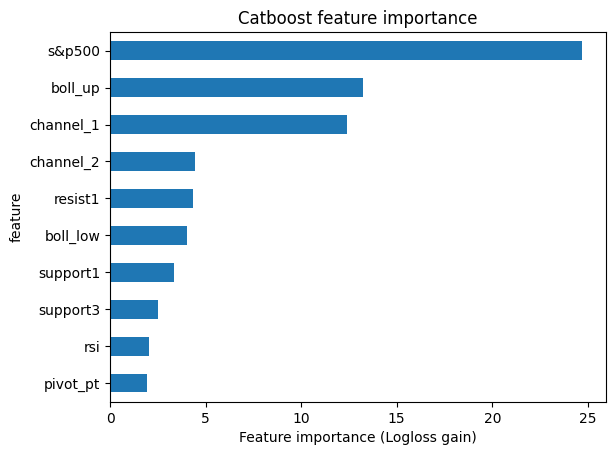

In [117]:
catboost_features.plot.barh(
    y="feature_importance (Logloss gain)", x="feature",
    legend=False
)

plt.title("Catboost feature importance")
plt.xlabel("Feature importance (Logloss gain)")

plt.savefig("catboost_features.png", bbox_inches="tight")

plt.show()

<h4>XGBoost</h4>

In [75]:
import xgboost as xgb

from sklearn.metrics import f1_score

In [76]:
reg_cols = num_cols + categorical_cols # numeric + dummy encoded columns

In [ ]:
def xgboost_objective(trial, dtrain: xgb.DMatrix, dval: xgb.DMatrix) -> float:

    params = {
        "objective": "binary:logistic",
        "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        "max_depth": trial.suggest_int('max_depth', 2, 10),
        "reg_alpha": trial.suggest_float('reg_alpha', 0.00001, 0.1, log=True),
        "reg_lambda": trial.suggest_float('reg_lambda', 0.00001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "gamma": trial.suggest_float("gamma", 0.01, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.01, 10),
        "tree_method": "gpu_hist",
        "eval_metric": ["logloss"]
    }

    evals_result = {}

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=[(dtrain, "train"), (dval, "val")],
        num_boost_round=5000, early_stopping_rounds=10,
        verbose_eval=False, evals_result=evals_result,
    )

    y_pred = model.predict(dval)
    y_pred = (y_pred > 0.5).astype(int)

    f1 = f1_score(y_true=dval.get_label(), y_pred=y_pred, average="micro")

    return f1

In [77]:
dtrain = xgb.DMatrix(data=df_train[reg_cols], label=df_train["result"])
dval = xgb.DMatrix(data=df_val[reg_cols], label=df_val["result"])
dtest = xgb.DMatrix(data=df_test[reg_cols], label=df_test["result"])

In [ ]:
study_xgboost = optuna.create_study(
    direction="maximize",
)

study_xgboost.optimize(
    partial(xgboost_objective, dtrain=dtrain, dval=dval),
    n_trials=20
)

In [78]:
best_xgboost_params = {
    'learning_rate': 0.030993596950263477,
    'max_depth': 9,
    'reg_alpha': 0.04275485366735886,
    'reg_lambda': 0.03482821938369906,
    'subsample': 0.9190874318673274,
    'gamma': 0.3125592022933006,
    'colsample_bytree': 0.8083969544573663,
    'scale_pos_weight': 0.7744797716232732
}

In [ ]:
study_xgboost.best_params

{'learning_rate': 0.030993596950263477,
 'max_depth': 9,
 'reg_alpha': 0.04275485366735886,
 'reg_lambda': 0.03482821938369906,
 'subsample': 0.9190874318673274,
 'gamma': 0.3125592022933006,
 'colsample_bytree': 0.8083969544573663,
 'scale_pos_weight': 0.7744797716232732}

<h4>Training tuned XGBoost model</h4>

In [79]:
xgboost_params = {
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "eval_metric": ["logloss"]
}

xgboost_params.update(best_xgboost_params)

In [ ]:
xgboost_model = xgb.train(
    params=xgboost_params,
    dtrain=dtrain,
    evals=[(dtrain, "train"), (dval, "val")],
    num_boost_round=5000, early_stopping_rounds=10,
    verbose_eval=True
)

In [101]:
# check target metric
y_pred = xgboost_model.predict(dval)
y_pred = (y_pred > 0.5).astype(int)

f1_score(y_pred=y_pred, y_true=df_val["result"], average="micro")

0.9383932755388941

In [118]:
importances = xgboost_model.get_score(importance_type="gain")

xgboost_features = pd.DataFrame(
    data=importances.items(), columns=["Feature", "Logloss gain"]
)

xgboost_features = xgboost_features.sort_values(
    by="Logloss gain", ascending=False
).head(10).iloc[::-1]

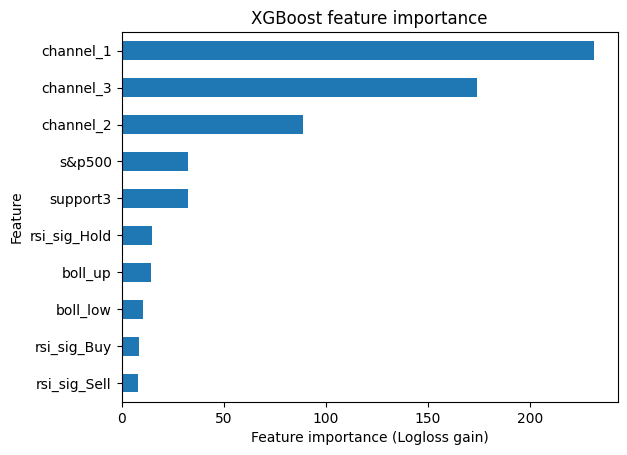

In [119]:
xgboost_features.plot.barh(
    y="Logloss gain", x="Feature",
    legend=False
)

plt.title("XGBoost feature importance")
plt.xlabel("Feature importance (Logloss gain)")

plt.savefig("xgboost_features.png", bbox_inches="tight")

plt.show()

<h4>Precision-Recall Curve and AUC</h4>

<p>Using PR-AUC (Area under the Precision-Recall Curve) will allow us to evaluate how good each model performs at each threshold level (any probability threshold $p \in [0, 1]$. Typically, the higher the PR curve the better the model performs no matter the probaility threshold (overall better)</p>

In [155]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, auc

In [150]:
cb_probs = model.predict_proba(val)[:, 0]
xgb_probs = 1 - xgboost_model.predict(dval)

In [151]:
prec_cb, recall_cb, _ = precision_recall_curve(y_true=df_val["result"], probas_pred=cb_probs, pos_label=0)
prec_xgb, recall_xgb, _ = precision_recall_curve(y_true=df_val["result"], probas_pred=xgb_probs, pos_label=0)

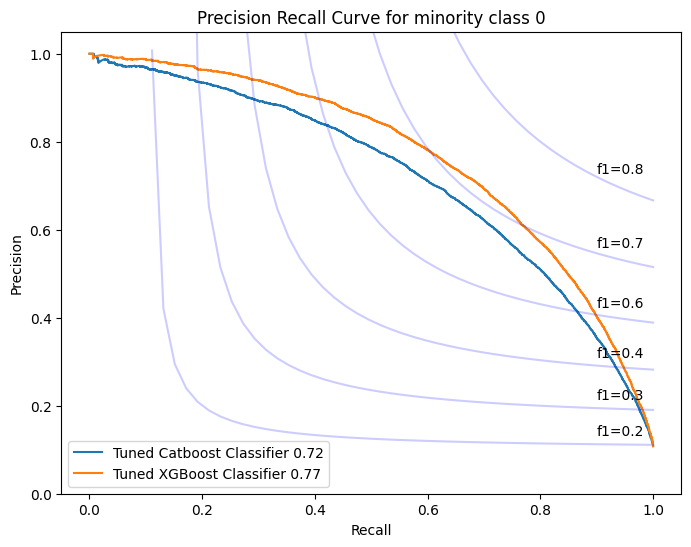

In [163]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

_ = PrecisionRecallDisplay(
    precision=prec_cb, recall=recall_cb
).plot(ax=ax, label=f"Tuned Catboost Classifier {round(auc(recall_cb, prec_cb), 2)}")

_ = PrecisionRecallDisplay(
    precision=prec_xgb, recall=recall_xgb
).plot(ax=ax, label=f"Tuned XGBoost Classifier {round(auc(recall_xgb, prec_xgb), 2)}")

f_scores = np.linspace(0.2, 0.8, num=6)

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="blue", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

plt.title("Precision Recall Curve for minority class 0")
plt.ylim([0.0, 1.05])

ax.legend()

plt.savefig("precision_recall.png", bbox_inches="tight")

plt.show()

<h4>Proba threshold vs f1 minority class</h4>

<p>Here we will have a look at how the probability threshold affect the f1 of the minority class, which is basically the same as can see above on the PR graph</p>

In [159]:
def f1_proba(
    model, data: Union[Pool, xgb.DMatrix], df_val: pd.DataFrame
) -> Dict[str, List[float]]:

    f1_min, f1_maj = [], []

    for threshold in tqdm(np.linspace(0, 1, 200)):
        y_pred = model.predict(data)
        y_pred = (y_pred > threshold).astype(int)

        f1_minority, f1_majority = f1_score(
            y_pred=y_pred, y_true=df_val["result"], average=None
        )

        f1_min.append(f1_minority)
        f1_maj.append(f1_majority)

    return {
        "f1_minority": np.array(f1_min),
        "f1_majority": np.array(f1_maj)
    }

In [160]:
xgb_prob_threshold = f1_proba(xgboost_model, dval, df_val)

100%|██████████| 200/200 [00:13<00:00, 15.35it/s]


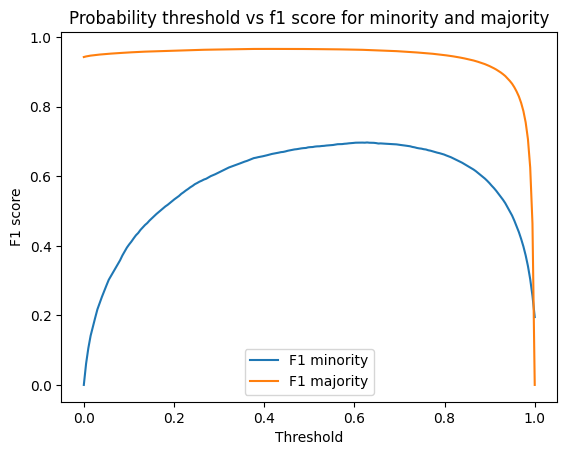

In [165]:
probs = np.linspace(0, 1, 200)

plt.title("Probability threshold vs f1 score for minority and majority")

plt.plot(probs, xgb_prob_threshold["f1_minority"], label="F1 minority")
plt.plot(probs, xgb_prob_threshold["f1_majority"], label="F1 majority")

plt.xlabel("Threshold")
plt.ylabel("F1 score")

plt.savefig("prob_threshold.png", bbox_inches="tight")

plt.legend()
plt.show()

In [166]:
best_threshold = probs[xgb_prob_threshold["f1_minority"].argmax()]

xgb_pred = xgboost_model.predict(dval)
best_xgb_pred = (xgb_pred > best_threshold).astype(int)

<h4>In the same fashion we can find best threshold for highest f1 micro</h4>

In [171]:
f1_scores = []

for threshold in tqdm(probs):
    y_pred = xgboost_model.predict(dval)
    y_pred = (y_pred > threshold).astype(int)
    f1_micro = f1_score(y_pred=y_pred, y_true=df_val["result"], average="micro")
    f1_scores.append(f1_micro)

f1_scores = np.array(f1_scores)

100%|██████████| 200/200 [00:13<00:00, 14.36it/s]


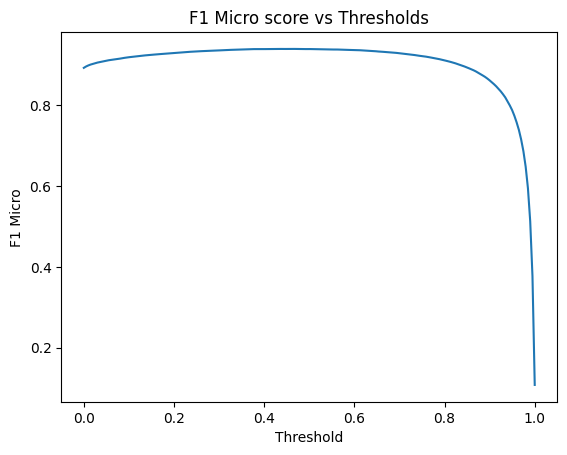

In [173]:
plt.title("F1 Micro score vs Thresholds")
plt.plot(probs, f1_scores)

plt.ylabel("F1 Micro")
plt.xlabel("Threshold")

plt.savefig("f1_micro.png", bbox_inches="tight")

plt.show()

In [175]:
best_f1_micro_threshold = probs[f1_scores.argmax()]

y_pred = xgboost_model.predict(dtest)
y_pred = (y_pred > best_f1_micro_threshold).astype(int)

f1_score(y_pred=y_pred, y_true=df_test["result"], average="micro")

0.9376962277413308

 <h4>Optuna + trial optimization within the trial</h4>
<p>We optimize parameters for the model itself as well as its threshold probability. Meaning that we optimize both model's hyperparameters as well as the probability threshold. By default 0.5 is used for binary classification, but sometimes we are better off being more certain about the prediction thus changing the probability threshold.</p>

In [176]:
optuna_thresholds: List[float] = []

def xgboost_objective(trial, dtrain: xgb.DMatrix, dval: xgb.DMatrix) -> float:

    params = {
        "objective": "binary:logistic",
        "learning_rate": trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        "max_depth": trial.suggest_int('max_depth', 2, 10),
        "reg_alpha": trial.suggest_float('reg_alpha', 0.00001, 0.1, log=True),
        "reg_lambda": trial.suggest_float('reg_lambda', 0.00001, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "gamma": trial.suggest_float("gamma", 0.01, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.01, 10),
        "tree_method": "gpu_hist",
        "eval_metric": ["logloss"]
    }

    evals_result = {}

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        evals=[(dtrain, "train"), (dval, "val")],
        num_boost_round=5000, early_stopping_rounds=10,
        verbose_eval=False, evals_result=evals_result,
    )

    pred_proba = model.predict(dval)

    f1_scores = []

    # optimize for threshold for the set of parameters
    thresholds = np.linspace(0, 1, 500)

    for threshold in thresholds:

        y_pred = (pred_proba > threshold).astype(int)
        f1_scores.append(
            f1_score(y_true=dval.get_label(), y_pred=y_pred, average="micro")
        )

    best_idx = np.argmax(f1_scores)
    best_score = np.max(f1_scores)

    optuna_thresholds.append(thresholds[best_idx])

    return best_score

In [ ]:
study_threshold_xgboost = optuna.create_study(
    direction="maximize",
)

study_threshold_xgboost.optimize(
    partial(xgboost_objective, dtrain=dtrain, dval=dval),
    n_trials=20
)

In [177]:
study_threshold_xgboost = {
  'learning_rate': 0.031313305697373575,
  'max_depth': 10,
  'reg_alpha': 4.559578794288777e-05,
  'reg_lambda': 0.009281758964961084,
  'subsample': 0.9446338481052298,
  'gamma': 0.4841920394976853,
  'colsample_bytree': 0.6182574051153801,
  'scale_pos_weight': 3.3143826765043873
}

<h4>Train and submit the model</h4>

<p>Leave out 5% validation set to make sure that model is trained optimally without overfitting and fitting avoiding manually choosing the number of boosting rounds and hoping this is the best.</p>

In [178]:
# train val split
df_train, df_val = train_test_split(
    df_scaled, train_size=0.95, shuffle=True, random_state=42
)

df_train.shape, df_val.shape

((1621836, 61), (85360, 61))

In [179]:
reg_cols = num_cols + categorical_cols

In [180]:
dtrain, dval = (
    xgb.DMatrix(data=df_train[reg_cols], label=df_train["result"]),
    xgb.DMatrix(data=df_val[reg_cols], label=df_val["result"])
)

In [181]:
xgboost_params = {
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    "eval_metric": ["logloss"]
}

xgboost_params.update(study_threshold_xgboost)

In [ ]:
# train the model 5000 boosting rounds but make sure to stop once for 10 rounds there is
# no improvement in terms of logloss

evals_result = {}

xgboost_model = xgb.train(
    params=xgboost_params,
    dtrain=dtrain,
    evals=[(dtrain, "train"), (dval, "val")],
    num_boost_round=5000, early_stopping_rounds=10,
    verbose_eval=True, evals_result=evals_result
)

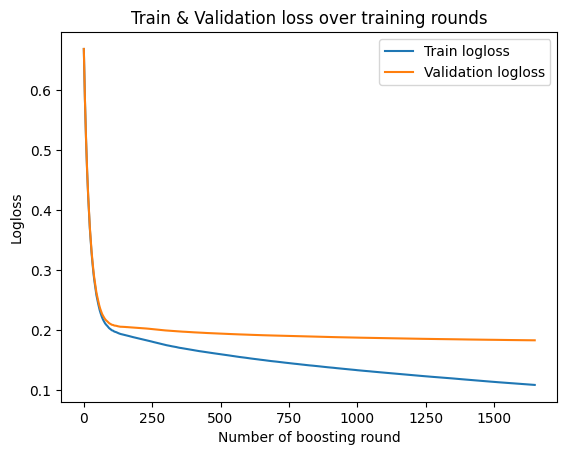

In [187]:
plt.plot(evals_result["train"]["logloss"], label="Train logloss")
plt.plot(evals_result["val"]["logloss"], label="Validation logloss")

plt.title("Train & Validation loss over training rounds")
plt.ylabel("Logloss")
plt.xlabel("Number of boosting round")

plt.legend()

plt.savefig("train_val_loss.png", bbox_inches="tight")

plt.show()

In [188]:
# find the best threshold for this configuration (it was calcultaed earlier but was lost)
f1_scores = []

probs = np.linspace(0, 1, 200)

for threshold in tqdm(probs):
    y_pred = xgboost_model.predict(dval)
    y_pred = (y_pred > threshold).astype(int)

    f1_micro = f1_score(y_pred=y_pred, y_true=df_val["result"], average="micro")
    f1_scores.append(f1_micro)

f1_scores = np.array(f1_scores)

100%|██████████| 200/200 [00:09<00:00, 20.92it/s]


In [189]:
print(f1_scores.max())

best_threshold = probs[f1_scores.argmax()]
best_threshold

0.9391635426429241


0.6934673366834171

In [195]:
y_pred = xgboost_model.predict(dval)
y_pred = (y_pred > best_threshold).astype(int)

f1_score(y_pred=y_pred, y_true=df_val["result"], average="micro")

0.9391635426429241

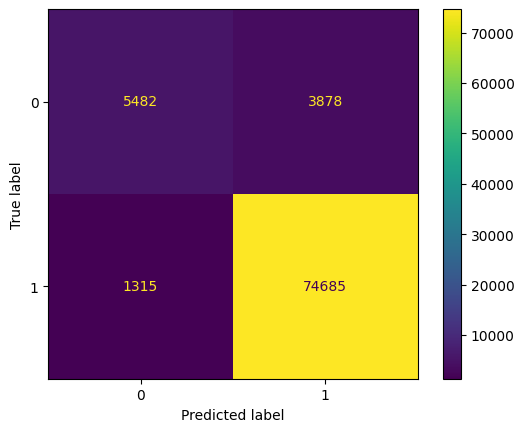

In [196]:
cm = confusion_matrix(y_pred=y_pred, y_true=df_val["result"])

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[0, 1]
).plot()

plt.show()

In [197]:
print(
    classification_report(y_true=df_val["result"], y_pred=y_pred)
)

              precision    recall  f1-score   support

         0.0       0.81      0.59      0.68      9360
         1.0       0.95      0.98      0.97     76000

    accuracy                           0.94     85360
   macro avg       0.88      0.78      0.82     85360
weighted avg       0.93      0.94      0.93     85360



<h4>Prepare for final submission</h4>

In [191]:
# load solution data
df_sol, _ = create_cat_cols(df_sol)

100%|██████████| 6/6 [00:00<00:00, 346.73it/s]


In [192]:
sol = xgb.DMatrix(data=df_sol[reg_cols])

y_pred = xgboost_model.predict(sol)
y_pred = (y_pred > best_f1_micro_threshold).astype(int)

In [193]:
pd.DataFrame({
    "ID": range(len(y_pred)),
    "result": y_pred
}).to_csv("solution_5.csv", index=False)